In [80]:
from PIL import Image
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets import load_dataset
from IPython.display import display
from trainer import trainer
import torchvision.models as models



In [81]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS!")
else:
    device = torch.device("cpu")
    print("Using CPU.")

Using MPS!


In [82]:
def get_pics(base, out_path):
    if base.name.lower().endswith((".jpg", ".jpeg", ".png")):
        image = Image.open(base).convert("RGB")
        image = image.resize((142, 183), resample=Image.LANCZOS)
        if "val" in base.name:
            image.save(f"{out_path}/val/{base.name}")
        else:
            image.save(f"{out_path}/train/{base.name}")
    elif base.is_dir():
        for file in base.iterdir():
            get_pics(file, out_path)

In [83]:
# from pathlib import Path

# get_pics(Path("imagenette2-320"), "content_images")

Shape: torch.Size([3, 183, 142])


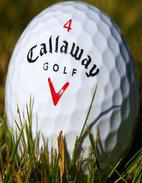

In [84]:
content_image = Image.open("../../content_images/train/n03445777_70.JPEG").convert("RGB")
transform = transforms.ToTensor()
tensor = transform(content_image)

print("Shape:", tensor.shape)  # (C, H, W)
display(content_image)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Image transformations (resize, tensor, normalize)
style_transform = transforms.Compose([
    transforms.Resize(size=(184,144)),
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize([0.5]*3, [0.5]*3)     # Normalize to [-1, 1]
])

content_transform = transforms.Compose([
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize([0.5]*3, [0.5]*3)     # Normalize to [-1, 1]
])

Shape: torch.Size([3, 300, 300])
Shape: tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 0.8275,  0.5373, -0.1137,  ...,  1.0000,  0.9922,  0.9922],
         [ 0.8745,  0.6471,  0.1216,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9137,  0.7255,  0.2941,  ...,  1.0000,  1.0000,  1.0000]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 0.8275,  0.5373, -0.1137,  ...,  1.0000,  0.9922,  0.9922],
         [ 0.8745,  0.6471,  0.1216,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9137,  0.7255,  0.2941,  ...,  1.0000,  1.0000,  1.0000]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
     

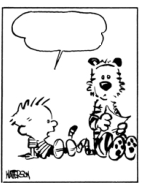

In [86]:
style_image = Image.open("../../OCR_PARSED_PANELS/panel_99.png").convert("RGB")
tensor = style_transform(style_image)

print("Shape:", tensor.shape)  # (C, H, W)
print("Shape:", tensor)  # (C, H, W)
display(style_image)


In [ ]:
# Dataset root folder
dataset_path = "../../content_images"

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=style_transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

In [88]:
# Load pretrained VGG16 features (no classifier)
# vgg16 = models.vgg16(pretrained=True).features.eval()

# # Save model weights
# torch.save(vgg16.state_dict(), "vgg16_features.pth")

In [89]:
from trainer import trainer
tensor = style_transform(style_image)
tr = trainer(tensor, 5, dataloader, device, 1e-4, 1e5)
tr.train()

Epoch [1], Batch [1], Content: 5.9563, Style: 22.7520, Total: 28.7083
Epoch [1], Batch [11], Content: 3.9918, Style: 4.9105, Total: 8.9023
Epoch [1], Batch [21], Content: 4.1905, Style: 4.8012, Total: 8.9917
Epoch [1], Batch [31], Content: 3.5710, Style: 4.6633, Total: 8.2343
Epoch [1], Batch [41], Content: 3.7812, Style: 4.4376, Total: 8.2188
Epoch [2], Batch [1], Content: 3.3836, Style: 4.1611, Total: 7.5447
Epoch [2], Batch [11], Content: 3.1470, Style: 3.7514, Total: 6.8984
Epoch [2], Batch [21], Content: 3.2468, Style: 3.6975, Total: 6.9442
Epoch [2], Batch [31], Content: 2.7412, Style: 3.4799, Total: 6.2211
Epoch [2], Batch [41], Content: 3.0773, Style: 3.2029, Total: 6.2803
Epoch [3], Batch [1], Content: 3.2563, Style: 3.0928, Total: 6.3492
Epoch [3], Batch [11], Content: 3.0263, Style: 3.1654, Total: 6.1917
Epoch [3], Batch [21], Content: 3.2028, Style: 2.8846, Total: 6.0874
Epoch [3], Batch [31], Content: 2.8775, Style: 2.8876, Total: 5.7651
Epoch [3], Batch [41], Content: 2.9

In [90]:
content_image = Image.open("../../content_images/yorkie.png").convert("RGB")
content_tensor = transform(content_image).unsqueeze(0).to(device)  # shape: (1, 3, H, W
with torch.no_grad():
    output = tr.model.net.forward(content_tensor)  # output shape: (1, 3, H, W)

In [91]:
import torchvision.transforms.functional as TF

# Unnormalize: [-1, 1] → [0, 1]
output = (output.clamp(-1, 1) + 1) / 2



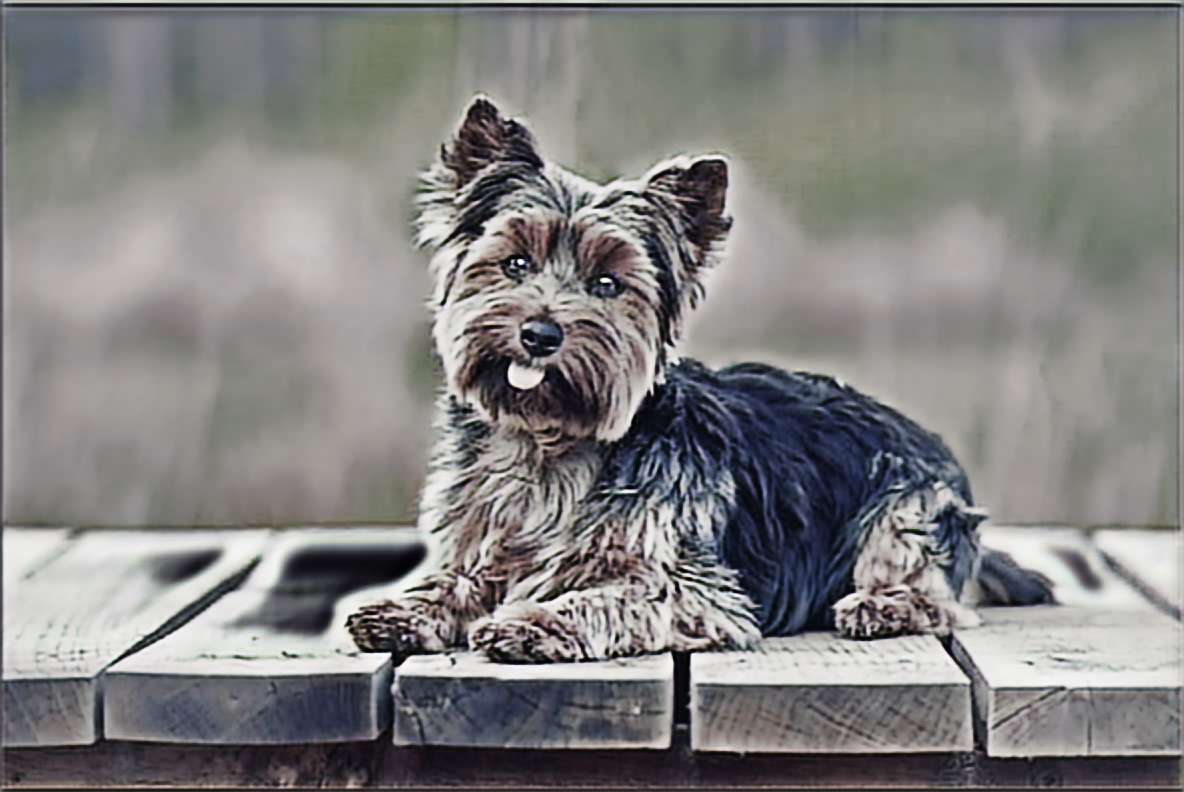

In [92]:
# Convert to PIL and save
stylized_image = TF.to_pil_image(output.squeeze(0).cpu())
display(stylized_image)